# SCC0275 - Introdução à Ciência de Dados
# Primeiro Projeto Prático

Nome: Enrico Vicenzo Salvador Robazza <br>
NUSP: 9806738

<hr>

### Instalar pacotes

Este código precisa de algumas bibliotecas para rodar.<br>
Abaixo estão os comando para sua instalação:

### Código Auxiliar

In [33]:
import pickle
import numpy as np

from itertools import product
from bitstring import BitArray, Bits, BitStream
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt


from PIL import Image
from io import BytesIO

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=rgb_id, length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

## Questão 1

### A)
Para que os níveis de quantização sejam o meio do intervalo quantizado, basta acrescentar metade do intervalo em cada um dos níveis.

In [4]:
def uniform_quant(im, n_colors, middle = False):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    if middle:
        ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size + bin_size // 2)
    else:
        ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1

    if middle:
        im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size + bin_size // 2)
    else:
        im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    # mat_ids é uma matriz da imagem, sendo que cada pixel é um id
    # dict_id2pixel é um dicionário de ids com a sua cor ([R, G, B]) correspondente
    return mat_ids, dict_id2pixel

### B)

In [5]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

In [6]:
img = load_sample_image("china.jpg")

In [50]:
new_img_packed = MyImgFormat(*uniform_quant(img, 64))
new_img = new_img_packed.unpack()

In [8]:
new_img_middle_packed = MyImgFormat(*uniform_quant(img, 64, True))
new_img_middle = new_img_middle_packed.unpack()

<Figure size 432x288 with 0 Axes>

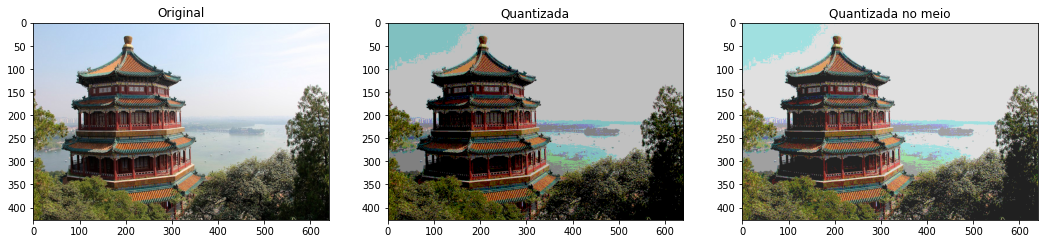

In [9]:
def show_multiple_images(images):
	plt.figure()
	f, subplots = plt.subplots(1, len(images), figsize=(18, 5))
	for i, title in enumerate(images):
		subplots[i].imshow(images[title])
		subplots[i].title.set_text(title)


show_multiple_images({
	"Original": img,
	"Quantizada": new_img,
	"Quantizada no meio": new_img_middle,
})


Com base nas imagens é possível notar a quantidade menor e cores nas imagens quantizadas, devido a mudanças mais bruscas de cores, principalmente no céu da imagem. Também é possível notar a diferença entre a imagem quantizada nos extremos e a imagem quantizada na metade, pois os pixels que antes eram pretos, se tornam mais claros.

### C)

In [82]:
print("Tamanho imagem original: %f"%get_bin_size_kb(img))
print("Tamanho imagem quantizada: %f"%get_bin_size_kb(new_img_packed))
print("Tamanho imagem quantizada para o meio intervalo: %f"%get_bin_size_kb(new_img_middle_packed))

Tamanho imagem original: 820.005000
Tamanho imagem quantizada: 206.208000
Tamanho imagem quantizada para o meio intervalo: 206.208000


É possível notar que que as imagens quantizadas possuem um tamanho significativamente menor do que a imagem original, o que está de acordo com o esperado. Também nota-se que as duas imagens, quantizada no começo dos níveis e quantizada no meio dos níveis, possuem o mesmo tamanho, o que também é de acordo com o esperado, pois a única diferença entre as duas são os valores das cores.

## Questão 2

### A)

In [51]:
def get_kmeans_img_and_inertia(img, k=64):
	X_img = img.reshape(-1, 3)
	kmeans = KMeans(
		n_clusters = k,
		max_iter=10,
		random_state=42
	)
	kmeans.fit(X_img)
	inertia = kmeans.inertia_
	clusters = kmeans.predict(X_img)
	img_clusters = clusters.reshape(img.shape[0], img.shape[1])

	dict_ids = {i: kmeans.cluster_centers_[i] for i in range(k)}

	return MyImgFormat(img_clusters, dict_ids), inertia

### B)

In [52]:
img_kmeans_packed, inertia = get_kmeans_img_and_inertia(img)
img_kmeans = img_kmeans_packed.unpack()

<Figure size 432x288 with 0 Axes>

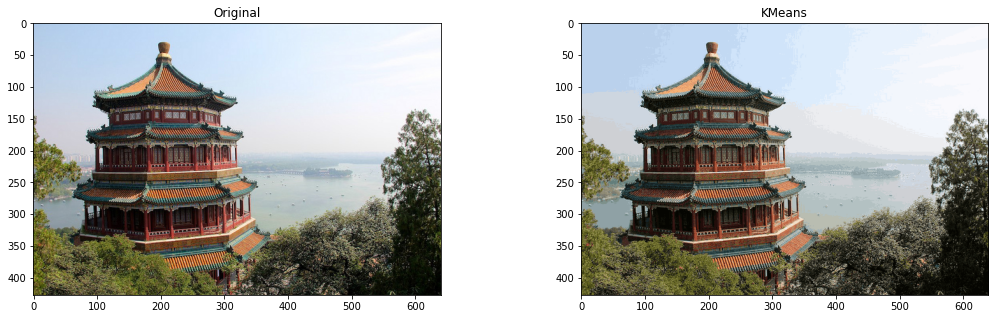

In [55]:
show_multiple_images({
	"Original": img, 
	"KMeans": img_kmeans
})

As cores da imagem quantizada com o KMeans são muito parecidas as da imagem original, a única diferença perceptível é nas transições de uma cor para outra, principalmente no céu e água.

## Questão 3

### A) 
	A função get_kmeans_img_and_inertia() foi modificada.


### B)
	Para calcular o MSE, basta calcularmos a soma das diferenças dos pixels, dividida pela área da imagem.

In [77]:
def calc_mse(img1, img2):
	_img1 = img1.astype("float")
	_img2 = img2.astype("float")
	M = float(img1.shape[0])
	N = float(img1.shape[1])
	return np.sum((_img1 - _img2)**2) / (M * N)


## Questão 4

### A)

In [78]:
img_china = img
img_flower = load_sample_image("flower.jpg")

colors_list = [8, 27, 64, 125, 216]

inertias_china = []
inertias_flower = []

mses_china_quant = []
mses_china_kmeans = []
mses_flower_quant = []
mses_flower_kmeans = []

sizes_china_quant = []
sizes_china_kmeans = []
sizes_flower_quant = []
sizes_flower_kmeans = []

for color in colors_list:
	new_china_unpacked = MyImgFormat(*uniform_quant(img_china, color))
	new_china = new_china_unpacked.unpack()

	new_flower_unpacked = MyImgFormat(*uniform_quant(img_flower, color))
	new_flower = new_flower_unpacked.unpack()

	mses_china_quant.append(calc_mse(img_china, new_china))
	mses_flower_quant.append(calc_mse(img_flower, new_flower))
	sizes_china_quant.append(get_bin_size_kb(new_china_unpacked))
	sizes_flower_quant.append(get_bin_size_kb(new_flower_unpacked))

	new_china_kmeans_packed, inertia = get_kmeans_img_and_inertia(img_china, color)
	new_china_kmeans = new_china_kmeans_packed.unpack()
	inertias_china.append(inertia)
	mses_china_kmeans.append(calc_mse(new_china_kmeans, img_china))
	sizes_china_kmeans.append(get_bin_size_kb(new_china_kmeans_packed))

	new_flower_kmeans_packed, inertia = get_kmeans_img_and_inertia(img_flower, color)
	new_flower_kmeans = new_flower_kmeans_packed.unpack()
	inertias_flower.append(inertia)
	mses_flower_kmeans.append(calc_mse(new_flower_kmeans, img_flower))
	sizes_flower_kmeans.append(get_bin_size_kb(new_flower_kmeans_packed))



<Figure size 432x288 with 0 Axes>

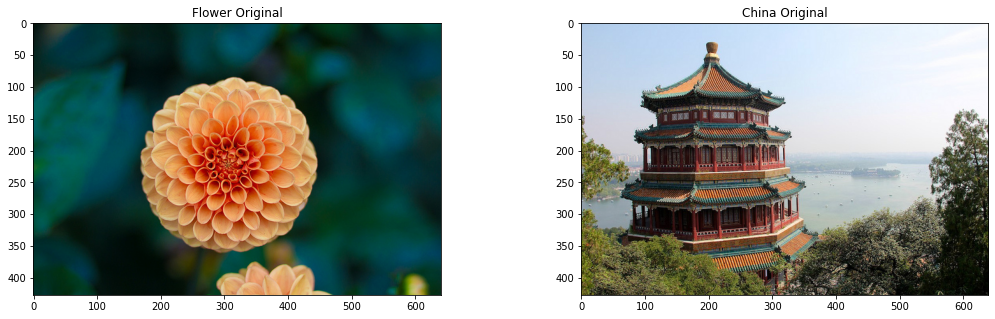

<Figure size 432x288 with 0 Axes>

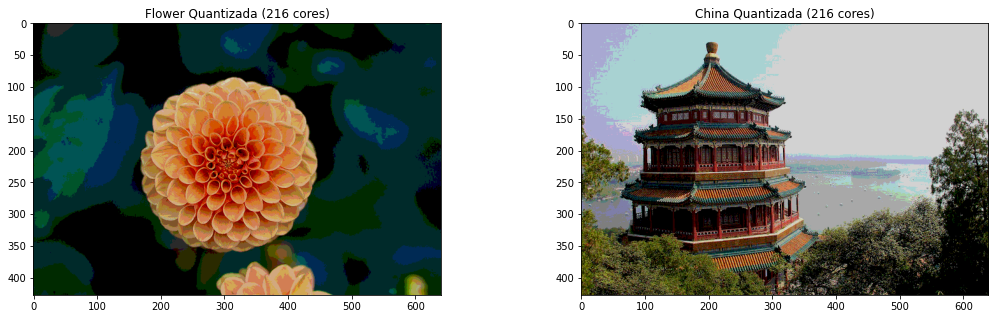

<Figure size 432x288 with 0 Axes>

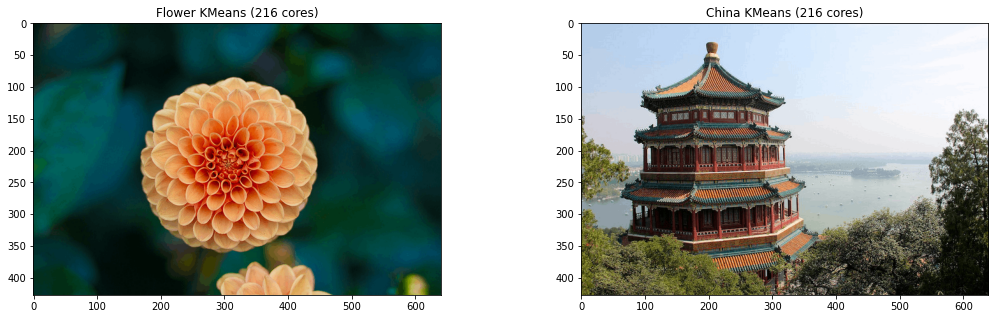

In [86]:
show_multiple_images({
	"Flower Original": img_flower,
	"China Original": img_china
})

show_multiple_images({
	"Flower Quantizada (216 cores)": new_flower,
	"China Quantizada (216 cores)": new_china
})

show_multiple_images({
	"Flower KMeans (216 cores)": new_flower_kmeans,
	"China KMeans (216 cores)": new_china_kmeans
})

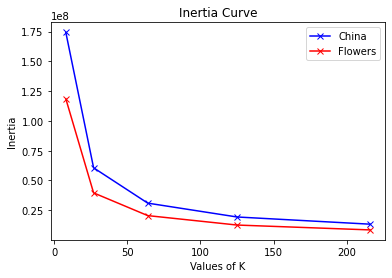

In [79]:
plt.plot(colors_list, inertias_china, 'bx-', label='China')
plt.plot(colors_list, inertias_flower, 'rx-', label='Flowers')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Inertia Curve')
plt.legend(loc="best")
plt.show()

Podemos notar que a inércia para a imagem das flores é menor do que para a imagem da China. Isso pode ser devido a uma presença de menos cores na imagem das flores, ou de um menor intervalo / maior concentração das cores.

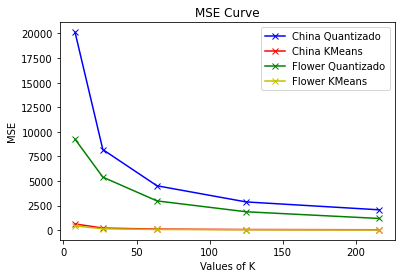

In [80]:
plt.plot(colors_list, mses_china_quant, 'bx-', label="China Quantizado")
plt.plot(colors_list, mses_china_kmeans, 'rx-', label="China KMeans")
plt.plot(colors_list, mses_flower_quant, 'gx-', label="Flower Quantizado")
plt.plot(colors_list, mses_flower_kmeans, 'yx-', label="Flower KMeans")
plt.xlabel('Values of K')
plt.ylabel('MSE')
plt.title('MSE Curve')
plt.legend(loc="best")
plt.show()


As curvas que tiveram um menor MSE foram as do KMeans, isso pode ser notado na comparação visual com as imagens originais, pois são as mais parecidas.

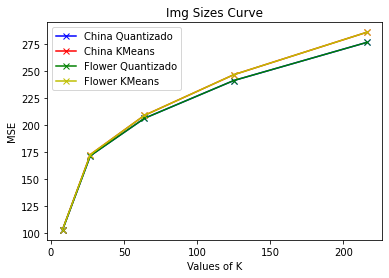

In [81]:
plt.plot(colors_list, sizes_china_quant, 'bx-', label="China Quantizado")
plt.plot(colors_list, sizes_china_kmeans, 'rx-', label="China KMeans")
plt.plot(colors_list, sizes_flower_quant, 'gx-', label="Flower Quantizado")
plt.plot(colors_list, sizes_flower_kmeans, 'yx-', label="Flower KMeans")

plt.xlabel('Values of K')
plt.ylabel('MSE')
plt.title('Img Sizes Curve')
plt.legend(loc="best")
plt.show()

Podemos notar que as imagens quantizadas utilizando o KMeans possuem um tamanho um pouco maior do que as quantizadas nos níveis de quantização.

## Conclusão

Com base nos resultados, podemos concluir que por um trade-off de um pouco mais de tamanho, as imagens quantizadas utilizando o KMeans possuem um resultado significativamente mais semelhante a imagem original, o que pode ser concluído tanto pela observação visual quanto pelo resultado do cálculo de MSE.